In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

os.chdir('C:\BTS_Master\Data_Driven\data')

In [13]:
def create_dictionaries(table):
    """
    connects with the database and extracts the data from the table, returns 2 dictionaries:
    the first with customers id as keys and the products as values ordered by date of subsciption
    the second with customers id as keys and the dates of the products as values ordered by date
    
    """
    # connecting with the database and querying it for the Customer ID and Products ordered by Date
    database = "C:\BTS_Master\Data_Driven\data\cajamar.db"
    connect = sqlite3.connect(database)
    query = "SELECT ID_Customer, Cod_Prod, Cod_Fecha FROM {} ORDER BY Cod_Fecha".format(table)
    query_result = pd.read_sql_query(query, connect)
    connect.close()
    
    dict_prod = {}
    for i in range(len(query_result)):
        # if the ID is already in the dictionary appends the product to the list, if not adds the Customer and the product
        if query_result.ID_Customer.values[i] in dict_prod:
            dict_prod[query_result.ID_Customer.values[i]].append(query_result.Cod_Prod.values[i])
        else:
            dict_prod[query_result.ID_Customer.values[i]] = [query_result.Cod_Prod.values[i]]
        
        
    dict_dates = {}
    for i in range(len(query_result)):
        # if the ID is already in the dictionary appends the product to the list, if not adds the Customer and the product
        if query_result.ID_Customer.values[i] in dict_dates:
            dict_dates[query_result.ID_Customer.values[i]].append(datetime.strptime(query_result.Cod_Fecha.values[i], '%Y-%m'))
        else:
            dict_dates[query_result.ID_Customer.values[i]] = [datetime.strptime(query_result.Cod_Fecha.values[i], '%Y-%m')]
            
    return dict_prod, dict_dates

In [14]:
def create_target(dict_prod):
    """ 
    takes the dictionary of products and removes the last product for each client creating a new dataframe for the target
    returns the dictionary of products without the target and a dataframe with the target
    """
    # create a new dictionary with the last product subscibed for each customer and deletes that product from the dictionary
    y = {}
    for key, value in dict_prod.items():
        y[key] = value.pop(-1)
        
    y_target = pd.DataFrame.from_dict(y, orient='index')
    y_target.reset_index(inplace=True)
    y_target.columns = [['ID_Customer','last_prod']]
    
    return dict_prod, y_target

In [15]:
def create_dataframe(original_file, dict_prod):
    """
    creates the dataframe with the IDs, socio demografics variables and products subscribed vector
    returns the dataframe
    """
    df = pd.read_csv(original_file + '.txt', sep='|')
    
    # get the ID and the number of products 
    data = df.groupby(['ID_Customer']).count()['Cod_Prod'].reset_index()
    data['num_products'] = data['Cod_Prod'] - 1
    data.drop('Cod_Prod', axis=1, inplace=True)

    data = data.merge(df.groupby(['ID_Customer']).mean()['Socio_Demo_01'].reset_index(), on='ID_Customer', how='left')
    data = data.merge(df.groupby(['ID_Customer']).mean()['Socio_Demo_02'].reset_index(), on='ID_Customer', how='left')
    data = data.merge(df.groupby(['ID_Customer']).mean()['Socio_Demo_03'].reset_index(), on='ID_Customer', how='left')
    data = data.merge(df.groupby(['ID_Customer']).mean()['Socio_Demo_04'].reset_index(), on='ID_Customer', how='left')
    data = data.merge(df.groupby(['ID_Customer']).mean()['Socio_Demo_05'].reset_index(), on='ID_Customer', how='left')
    
    
    products = [value for value in df['Cod_Prod'].unique()]
    for i in range(len(products)):
        lista = []
        for key, value in dict_prod.items():
            if products[i] in value:
                lista.append([key, 1])
        dataframe = pd.DataFrame(lista)
        # there are products never subscribed, this gives error trying to make the dataframe
        try:
            dataframe.columns = [['ID_Customer', 'Prod_'+str(products[i])]]
            data = data.merge(dataframe, on='ID_Customer', how='left')
        # will print a message if the product was not subscribed and create a column of zeros
        except ValueError:
            print('The product {} was never subscribed'.format(products[i]))
            data['Prod_'+str(products[i])] = np.zeros(len(data))
            
    # replace the NaN for Zeros
    for column in data.columns:
        data[column].fillna(0, inplace=True)
            
    return data

In [16]:
def dates_dataframe(dict_dates):
    """
    first deletes the last date from each customer, this is the date of the target
    then creates a dataframe with the date of the oldest product and the date of the most recent one
    returns the dataframe
    """
    # delete most recent date for each customer, this is the date of the target
    for key, value in dict_dates.items():
        value.pop(-1)
        
    dates = []
    for key, value in dict_dates.items():
        try:
            dates.append([key, value[0], value[-1]])
        except IndexError:
            dates.append([key])  
            
    df_dates = pd.DataFrame(dates, columns=['ID_Customer', 'old', 'recent'])
    
    return df_dates

In [17]:
def get_previous(dict_products, dataframe, pre_previous=False):
    """
    get the previous product for each client from the dictionary and create a new column in the dataframe with the products
    returns the new dataframe
    if pre_previous is True does the same to the product before the previous
    """
    previous = []
    for key, value in dict_products.items():
        try:
            previous.append([key, value[-1]])
        except IndexError:
            previous.append([key, 0])
    #  create DataFrame and merge
    previ = pd.DataFrame(previous)
    previ.columns = ['ID_Customer', 'previous']      
    dataframe = dataframe.merge(previ, on='ID_Customer')
    
    if pre_previous:
        pre_previous = []
        for key, value in dict_products.items():
            try:
                pre_previous.append([key, value[-2]])
            except IndexError:
                pre_previous.append([key, 0])
                
    pre_previ = pd.DataFrame(pre_previous)
    pre_previ.columns = ['ID_Customer', 'pre_previous']
    dataframe = dataframe.merge(pre_previ, on='ID_Customer')

    return dataframe

In [ ]:
train_prod, train_dates = create_dictionaries('train')
train_prod, train_target = create_target(train_prod)
train_target.head()

,ID_Customer,last_prod
0,A0495929,706
1,A0495930,706
2,A0495990,706
3,A0495941,301
4,A0495975,301


In [ ]:
train_data = create_dataframe('train', train_prod)
train_data.head()

In [9]:
train_dates = dates_dataframe(train_dates)
train_dates.head()

,ID_Customer,old,recent
0,A0495929,1954-03-01,2013-03-01
1,A0495930,1954-03-01,2014-07-01
2,A0495990,1954-09-01,2014-12-01
3,A0495941,1956-05-01,1956-05-01
4,A0495975,1956-11-01,1956-11-01


In [10]:
test_prod, test_dates = create_dictionaries('test')

test_prod, test_target = create_target(test_prod)

test_data = create_dataframe('test', test_prod)

test_dates = dates_dataframe(test_dates)

The product 1308 was never subscribed


In [11]:
test_data.head()

,ID_Customer,num_products,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_04,Socio_Demo_05,Prod_601,Prod_301,Prod_1021,...,Prod_706,Prod_707,Prod_1305,Prod_2502,Prod_1806,Prod_2201,Prod_502,Prod_9992,Prod_2901,Prod_1308
0,B0676372,0,5.0,5.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,B0676373,0,5.0,5.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,B0676374,8,3.0,5.0,3.0,1.0,3.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,B0676376,4,5.0,5.0,3.0,2.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,B0676377,1,5.0,5.0,3.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
test_dates.head()

,ID_Customer,old,recent
0,B0891376,1954-01-01,1954-01-01
1,B0889436,1954-09-01,2016-01-01
2,B0889461,1957-01-01,2013-03-01
3,B0889491,1959-02-01,2013-06-01
4,B0889492,1959-02-01,2013-06-01


In [13]:
train_data = get_previous(train_prod, train_data, pre_previous=True)
test_data = get_previous(test_prod, test_data, pre_previous=True)

In [14]:
train_data.head()

,ID_Customer,num_products,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_04,Socio_Demo_05,Prod_601,Prod_704,Prod_2501,...,Prod_803,Prod_1308,Prod_2901,Prod_1312,Prod_502,Prod_2801,Prod_104,Prod_504,previous,pre_previous
0,A0000001,4,5.0,4.0,3.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1011,601
1,A0000002,3,5.0,5.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,801,601
2,A0000003,4,5.0,5.0,5.0,2.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,301,2503
3,A0000004,3,5.0,5.0,3.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201,301
4,A0000005,1,5.0,5.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,301,0


In [15]:
print('oldest client in train data:', min(train_dates.old))
print('oldest client in test data:', min(test_dates.old))

oldest client in train data: 1954-03-01 00:00:00
oldest client in test data: 1954-01-01 00:00:00


In [16]:
print('most recent product in train data:', max(train_dates.recent))
print('most recent product in test data:', max(test_dates.recent))

most recent product in train data: 2017-03-01 00:00:00
most recent product in test data: 2017-01-01 00:00:00


#### will use the most recent date as current date

In [17]:
current_date = max(train_dates.recent)

In [18]:
def from_current_date(date):
    try:
        days = (date - current_date).days
    except:
        days = 0
    return days

def time_variables(dataset, dates_dataset):
    """
    """
    # get the number of days since the oldest product subscribed and since the most recent one
    dates_dataset['delta_old'] = dates_dataset['old'].apply(from_current_date)
    dates_dataset['delta_recent'] = dates_dataset['recent'].apply(from_current_date)
    
    dataset = dataset.merge(dates_dataset.drop(['old', 'recent'], axis=1), on='ID_Customer', how='left')
    
    # divide the difference of time between products by the number of products subscribed
    dataset['dif_days_product'] = dataset.apply(lambda row: 0 if np.isnan(row['delta_old']) else (row['delta_old'] + row['delta_recent']) / row['num_products'], axis=1)
    
    # divide the number of days since the oldest product by the number of products subscribed
    dataset['days_product'] = dataset.apply(lambda row: 0 if np.isnan(row['delta_old']) else row['delta_old'] / row['num_products'], axis=1)
    
    return dataset

In [19]:
train_data = time_variables(train_data, train_dates)
train_data.head()

,ID_Customer,num_products,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_04,Socio_Demo_05,Prod_601,Prod_704,Prod_2501,...,Prod_502,Prod_2801,Prod_104,Prod_504,previous,pre_previous,delta_old,delta_recent,dif_days_product,days_product
0,A0000001,4,5.0,4.0,3.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1011,601,-4018.0,-2161.0,-1544.750000,-1004.500000
1,A0000002,3,5.0,5.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,801,601,-8036.0,-4046.0,-4027.333333,-2678.666667
2,A0000003,4,5.0,5.0,5.0,2.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,301,2503,-11443.0,-1765.0,-3302.000000,-2860.750000
3,A0000004,3,5.0,5.0,3.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,201,301,-3226.0,-821.0,-1349.000000,-1075.333333
4,A0000005,1,5.0,5.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,301,0,-12022.0,-12022.0,-24044.000000,-12022.000000


In [20]:
test_data = time_variables(test_data, test_dates)
test_data.head()

,ID_Customer,num_products,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_04,Socio_Demo_05,Prod_601,Prod_301,Prod_1021,...,Prod_502,Prod_9992,Prod_2901,Prod_1308,previous,pre_previous,delta_old,delta_recent,dif_days_product,days_product
0,B0676372,0,5.0,5.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,NaN,NaN,0.00,0.000
1,B0676373,0,5.0,5.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,NaN,NaN,0.00,0.000
2,B0676374,8,3.0,5.0,3.0,1.0,3.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,9992,1011,-7883.0,-759.0,-1080.25,-985.375
3,B0676376,4,5.0,5.0,3.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,707,201,-4687.0,-243.0,-1232.50,-1171.750
4,B0676377,1,5.0,5.0,3.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,601,0,-7456.0,-7456.0,-14912.00,-7456.000


In [21]:
def merge_xy_save(x_data, y_data, name):
    """
    merges x data and y data and saves the file
    """
    data = x_data.merge(y_data, on='ID_Customer', how='left')
    
    data.to_csv(name)

In [22]:
merge_xy_save(train_data, train_target, 'new_train3.csv')
merge_xy_save(test_data, test_target, 'new_test3.csv')

In [3]:
train_data = pd.read_csv('new_train3.csv')
test_data = pd.read_csv('new_test3.csv')

In [5]:
train_data.shape

(676370, 109)

In [6]:
test_data.shape

(258989, 109)

#### join all the data and get dumies for the categorical variables and then separate again

In [7]:
new = pd.concat([train_data, test_data])

In [8]:
new = pd.get_dummies(new,columns=['Socio_Demo_01'],drop_first=True)
new = pd.get_dummies(new,columns=['Socio_Demo_02'],drop_first=True)
new = pd.get_dummies(new,columns=['Socio_Demo_03'],drop_first=True)
new = pd.get_dummies(new,columns=['Socio_Demo_04'],drop_first=True)
new = pd.get_dummies(new,columns=['Socio_Demo_05'],drop_first=True)
new = pd.get_dummies(new,columns=['previous'],drop_first=True)
new = pd.get_dummies(new,columns=['pre_previous'],drop_first=True)

In [9]:
train_data = new.iloc[:676370]
test_data = new.iloc[676371:]

## Random Forests

### Training and testing on the train file with spliting

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_data['last_prod'])

In [11]:
model = RandomForestClassifier(n_estimators=100, max_features=0.2, min_samples_leaf=50, criterion='entropy')
model.fit(X_train.fillna(0).drop(['ID_Customer', 'last_prod', 'Unnamed: 0'], axis=1), y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
print(accuracy_score(y_test, model.predict(X_test.fillna(0).drop(['ID_Customer', 'last_prod', 'Unnamed: 0'], axis=1))))

0.575310627879


### Train on training file and testing on test file

In [39]:
model = RandomForestClassifier(n_estimators=100, max_features=0.2, min_samples_leaf=50, criterion='entropy')
model.fit(train_data.fillna(0).drop(['ID_Customer', 'last_prod', 'Unnamed: 0'], axis=1), train_data['last_prod'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [40]:
print(accuracy_score(test_data['last_prod'], model.predict(test_data.fillna(0).drop(['ID_Customer', 'last_prod', 'Unnamed: 0'], axis=1))))

0.443561091634


### Features importance

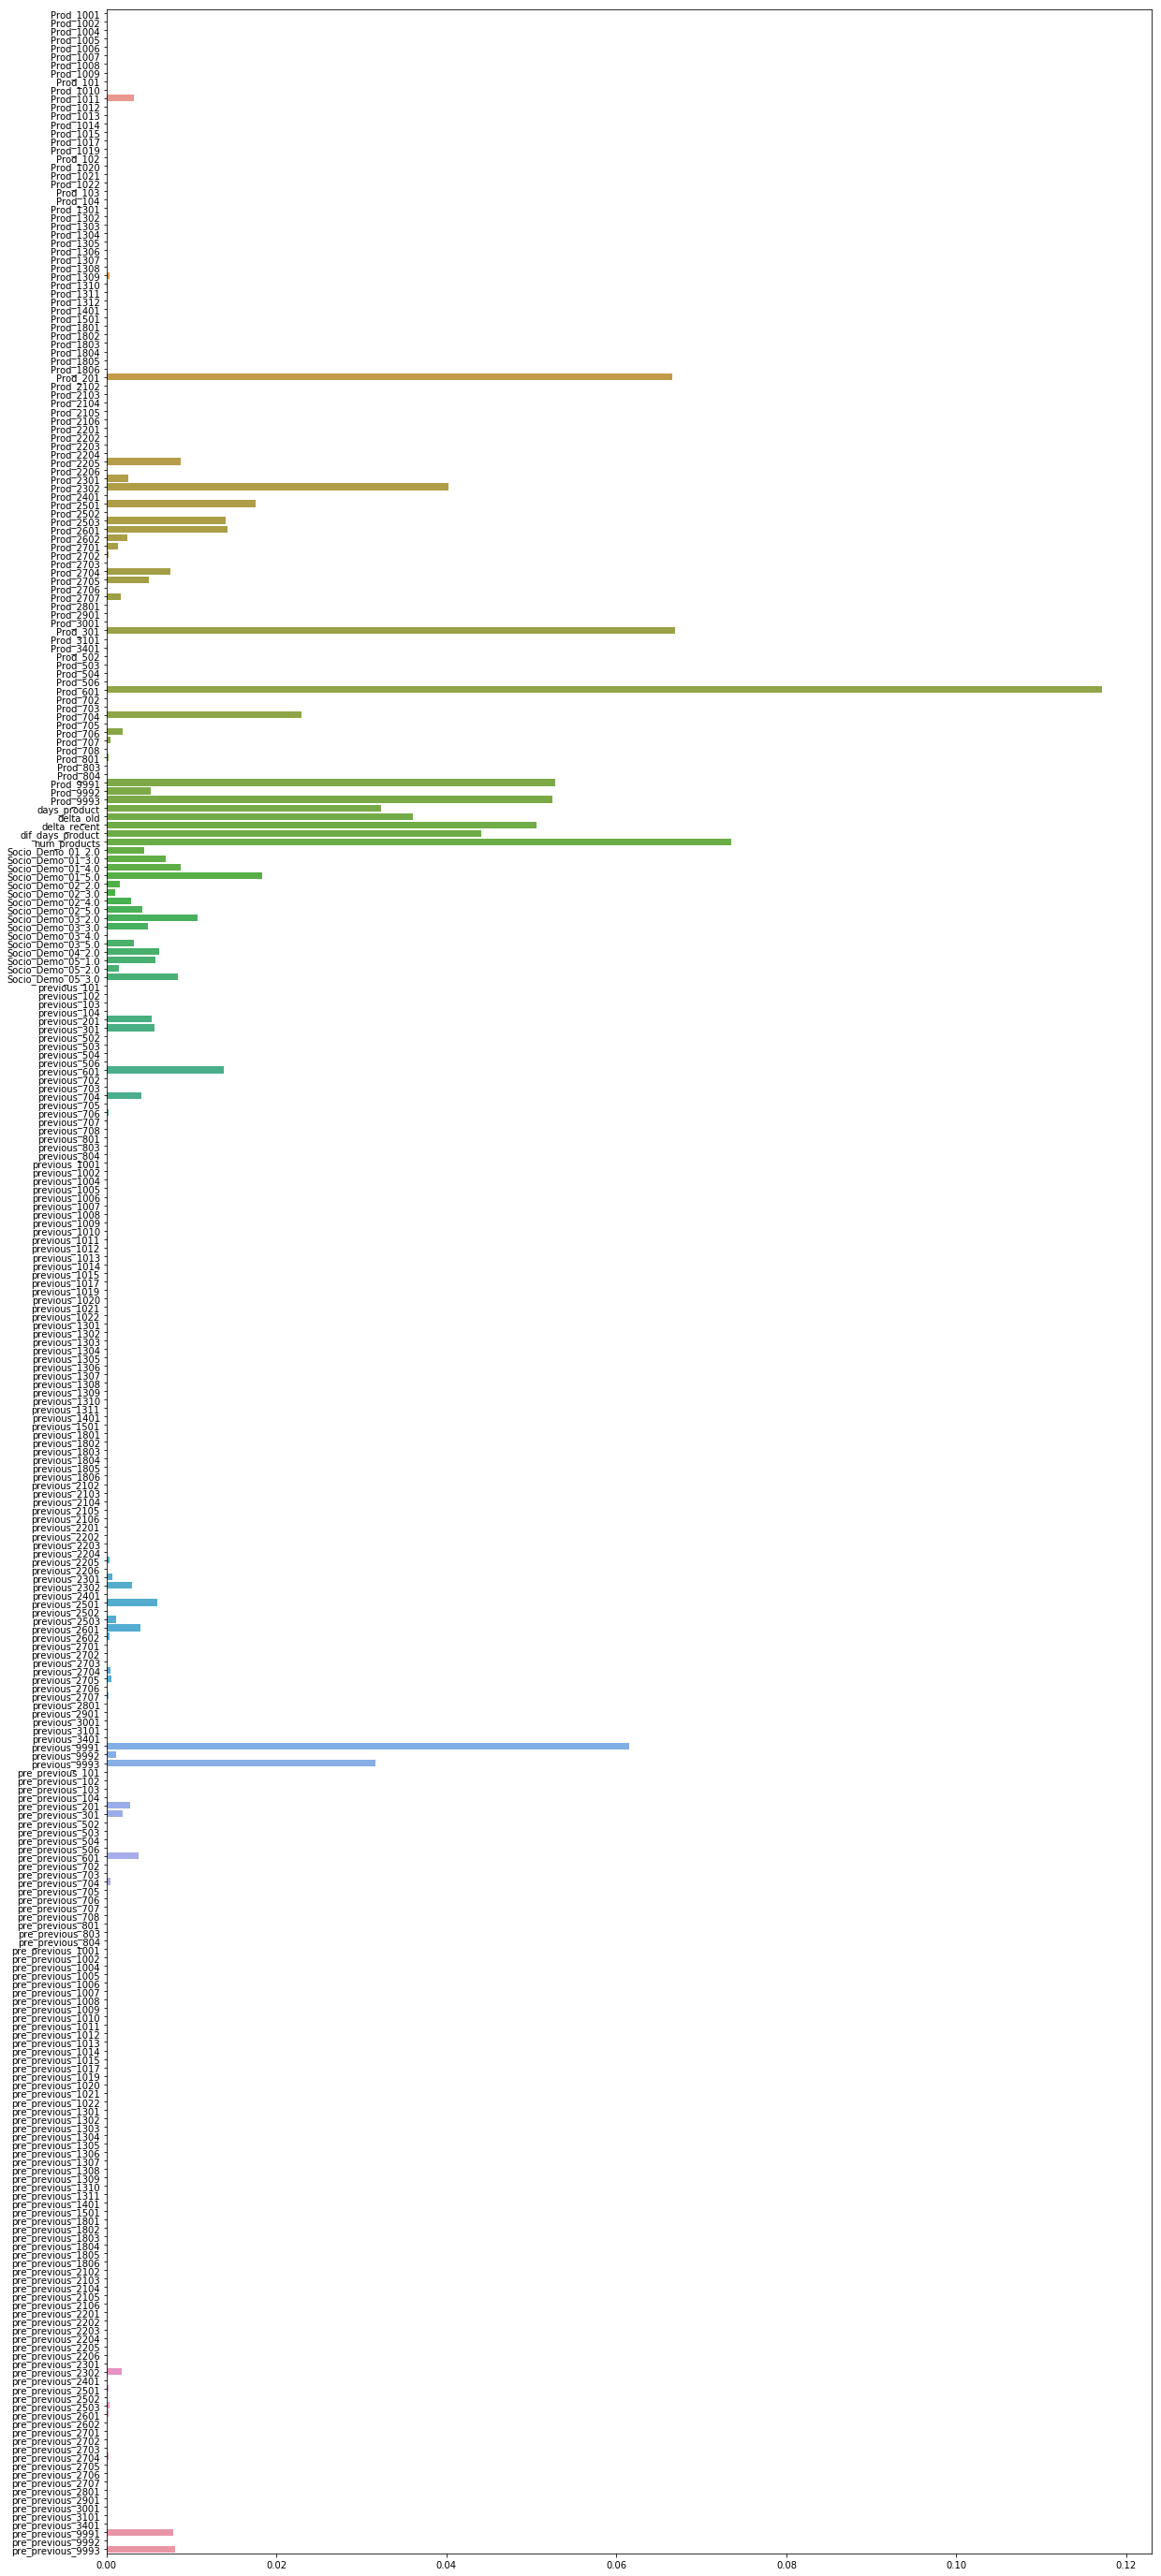

In [16]:
plt.figure(figsize=(20,50))
sns.barplot(model.feature_importances_, train_data.drop(['ID_Customer','Unnamed: 0', 'last_prod'], axis=1).columns)

## XGBOOST

In [2]:
import xgboost as xgb

In [3]:
train_data = pd.read_csv('new_train3.csv')
test_data = pd.read_csv('new_test3.csv')

In [4]:
new = pd.concat([train_data, test_data])

#### encode last product

In [5]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
le = LabelEncoder()
le.fit(new['last_prod'])
le.classes_

array([ 101,  102,  103,  104,  201,  301,  503,  504,  506,  601,  702,
        703,  704,  705,  706,  707,  708,  801,  803,  804, 1001, 1002,
       1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014,
       1015, 1017, 1019, 1020, 1021, 1022, 1301, 1302, 1303, 1304, 1305,
       1306, 1307, 1308, 1309, 1310, 1311, 1401, 1501, 1801, 1802, 1803,
       1804, 1805, 1806, 2102, 2103, 2104, 2105, 2106, 2201, 2202, 2203,
       2204, 2205, 2206, 2301, 2302, 2401, 2501, 2503, 2601, 2602, 2701,
       2702, 2703, 2704, 2705, 2706, 2707, 2801, 2901, 3001, 3101, 3401,
       9991, 9992, 9993], dtype=int64)

In [6]:
target = le.transform(new['last_prod'])

#### normalize the columns with days

In [7]:
from sklearn.preprocessing import normalize

In [8]:
to_normalize = new[['delta_old', 'delta_recent', 'dif_days_product', 'days_product']].fillna(0)

In [9]:
normalized = normalize(to_normalize, norm='l2')

In [10]:
new[['delta_old', 'delta_recent', 'dif_days_product', 'days_product']] = normalized

In [11]:
new.head()

,ID_Customer,Prod_1001,Prod_1002,Prod_1004,Prod_1005,Prod_1006,Prod_1007,Prod_1008,Prod_1009,Prod_101,...,Socio_Demo_05,Unnamed: 0,days_product,delta_old,delta_recent,dif_days_product,last_prod,num_products,pre_previous,previous
0,A0000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,-0.204154,-0.816614,-0.439199,-0.313953,704,4,601,1011
1,A0000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,-0.262234,-0.786702,-0.396092,-0.394265,9992,3,601,801
2,A0000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2,-0.231169,-0.924675,-0.142624,-0.266825,201,4,2503,301
3,A0000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3,-0.286809,-0.860427,-0.218974,-0.359800,2301,3,301,201
4,A0000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4,-0.377964,-0.377964,-0.377964,-0.755929,601,1,0,301


In [12]:
new = pd.get_dummies(new,columns=['Socio_Demo_01'],drop_first=True)
new = pd.get_dummies(new,columns=['Socio_Demo_02'],drop_first=True)
new = pd.get_dummies(new,columns=['Socio_Demo_03'],drop_first=True)
new = pd.get_dummies(new,columns=['Socio_Demo_04'],drop_first=True)
new = pd.get_dummies(new,columns=['Socio_Demo_05'],drop_first=True)
# new = pd.get_dummies(new,columns=['previous'],drop_first=True)

In [13]:
train_target = target[:676370]
test_target = target[676371:]

In [14]:
train_data = new[:676370]
test_data = new[676371:]

In [17]:
dtrain=xgb.DMatrix(train_data.fillna(0).drop(['ID_Customer', 'last_prod', 'Unnamed: 0', 'pre_previous'], axis=1),label=train_target)
dtest=xgb.DMatrix(test_data.fillna(0).drop(['ID_Customer', 'last_prod', 'Unnamed: 0', 'pre_previous'], axis=1), label=test_target)

In [18]:
parameters={'max_depth':8, 'eta':1,'objective':'multi:softmax','eval_metric':'mlogloss','learning_rate':0.05, 'num_class':91}
num_round=10
xg=xgb.train(parameters,dtrain,num_round)

In [19]:
predictions = xg.predict(dtest)

In [20]:
print(accuracy_score(le.transform(test_data['last_prod']), predictions))

0.443561091634


In [13]:
from sklearn.ensemble import AdaBoostClassifier

In [51]:
ada = AdaBoostClassifier(n_estimators=300)
ada.fit(train_data.fillna(0).drop(['ID_Customer', 'last_prod', 'Unnamed: 0'], axis=1), train_data['last_prod'])

MemoryError: 

In [20]:
print(accuracy_score(test_data['last_prod'], ada.predict(test_data.fillna(0).drop(['ID_Customer', 'last_prod', 'Unnamed: 0'], axis=1))))

0.0836834139033


In [28]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=50)

In [35]:
gb.fit(train_data.fillna(0).drop(['ID_Customer', 'last_prod', 'Unnamed: 0'], axis=1), train_data['last_prod'])

KeyboardInterrupt: 